In [12]:
# Significance plotting

# importing all needed functions
import os
from astropy.io import fits
import numpy as np
import glob
from Tools import tools
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba import jit
import os
from line_profiler import profile
%load_ext line_profiler
import pandas as pd

# Accessing the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [13]:

# Define the directory path
directory = r"C:\Users\arpan\Downloads\Uncertain\Uncertain"

# Initialize lists to store folder names and TRIG_SIG values
folders = []
trig_sig_values = []

# Traverse the directory and find all folders
for root, dirs, files in os.walk(directory):
    for dir_name in dirs:
        folders.append(dir_name)
        # Add a placeholder value for TRIG_SIG (you can modify this as needed)
        trig_sig_values.append(0.0)  # Replace None with actual values if available
    break  # Stop after the top-level directories to avoid subdirectories

# Create a DataFrame
df = pd.DataFrame({
    'filename': folders,
    'TRIG_SIG': trig_sig_values
})

# Display the DataFrame
print(df)

               filename  TRIG_SIG
0   BELOWHZ_bn091216359       0.0
1   BELOWHZ_bn110808375       0.0
2   BELOWHZ_bn120315329       0.0
3   BELOWHZ_bn120605953       0.0
4   BELOWHZ_bn120617678       0.0
..                  ...       ...
85  UNRELOC_bn201217806       0.0
86  UNRELOC_bn210527628       0.0
87  UNRELOC_bn210807895       0.0
88  UNRELOC_bn210829572       0.0
89  UNRELOC_bn221206544       0.0

[90 rows x 2 columns]


In [14]:
error_files = []


# updating the significance and class column
for index, row in df.iterrows():
    # skip duplicates
    if str(row['filename']).endswith('d'):
        print(f"Skipping {row['filename']}")
        continue
    # check if the filename is in the folders and isn't updated
    if row['filename'] in folders and row['TRIG_SIG'] == 0:

        # get the file path
        folder = os.path.join(r"C:\Users\arpan\Downloads\Uncertain\Uncertain" , row['filename'])

        # Finding Trigdat file
        trig_string = "_trigdat_"
        trig_pattern = os.path.join(folder, 'current', f"*{trig_string}*")
        trigdat_file = glob.glob(trig_pattern)

        # getting the significance
        try:
            with fits.open(trigdat_file[0], memmap=True) as hdul:
                df.at[index, 'TRIG_SIG'] = hdul[0].header['TRIG_SIG']
        except:
            print(f"Error in {trigdat_file[0]}")
            error_files.append(trigdat_file[0])
    

print(len(error_files))

0


In [15]:
# add a coloumn called 'class' and fill it with the value 'UNCERT'
df['class'] = 'UNCERT'
# add a column called 'category' and fill it with the value 'other'
df['category'] = 'uncert'

# shift the last column to be the second column
cols = list(df.columns)
cols.insert(1, cols.pop(-1))
df = df[cols]


print(df.head())


              filename category  TRIG_SIG   class
0  BELOWHZ_bn091216359   uncert       5.7  UNCERT
1  BELOWHZ_bn110808375   uncert       5.0  UNCERT
2  BELOWHZ_bn120315329   uncert       6.1  UNCERT
3  BELOWHZ_bn120605953   uncert       5.1  UNCERT
4  BELOWHZ_bn120617678   uncert       4.5  UNCERT


In [ ]:
# import the events.csv file and append this df to it and save it
# Import the events.csv file
events_df = pd.read_csv('events.csv')

# Concatenate the dataframes
updated_df = pd.concat([events_df, df], ignore_index=True)

print(updated_df.head())

print(updated_df.info())

# # Save the updated dataframe back to events.csv
# updated_df.to_csv('events.csv', index=False)

             filename category  TRIG_SIG   class
0  SFLARE_bn140204646    train       7.8  SFLARE
1     GRB_bn101208498    other       0.0     GRB
2     TGF_bn190821888     test       5.2     TGF
3  SFLARE_bn240208118    train       6.5  SFLARE
4  SFLARE_bn240204601    train       5.8  SFLARE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4464 entries, 0 to 4463
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  4464 non-null   object 
 1   category  4464 non-null   object 
 2   TRIG_SIG  4464 non-null   float64
 3   class     4464 non-null   object 
dtypes: float64(1), object(3)
memory usage: 139.6+ KB
None


In [21]:
for index, row in df.iterrows():
    if row['TRIG_SIG'] == 0:
        print('hi')

In [31]:
print(df['TRIG_SIG'].mean())

5.2266666666666675


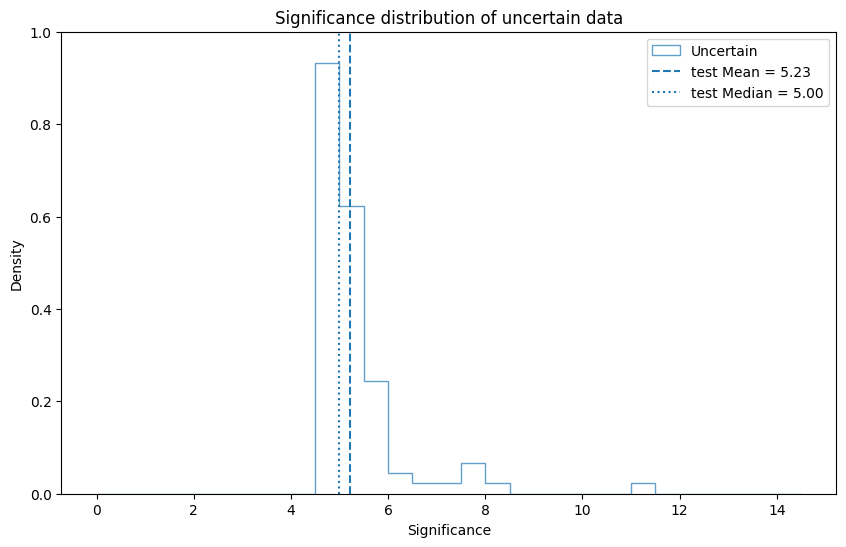

In [36]:
# plot of significance
bin_size = 0.5
bins = np.arange(0, 15, bin_size)

plt.figure(figsize=(10, 6))
plt.hist(df['TRIG_SIG'], bins=bins, rwidth = 0.9, histtype='step', alpha=0.7 , density= True, label='Uncertain')
plt.vlines(df['TRIG_SIG'].mean(), 0, 1, colors=colors[0], linestyles='dashed', label=f"test Mean = {df['TRIG_SIG'].mean():.2f}")
plt.vlines(df['TRIG_SIG'].median(), 0, 1, colors=colors[0], linestyles='dotted', label=f"test Median = {df['TRIG_SIG'].median():.2f}")

plt.xlabel('Significance')
plt.ylabel('Density')
plt.ylim(0, 1)
plt.legend()
plt.title('Significance distribution of uncertain data')

plt.show()

Training set: 2800
max: 100.5 	 min: 0.0
Median = 5.7
Trimmed Training set: 2520
max: 12.6 	 min: 4.6
Mean = 6.2288492063492065
 --------------------------------
Test set: 692
max: 38.5 	 min: 0.0
Median = 5.7
Trimmed test set: 623
max: 11.2 	 min: 4.6
Mean = 6.108667736757625


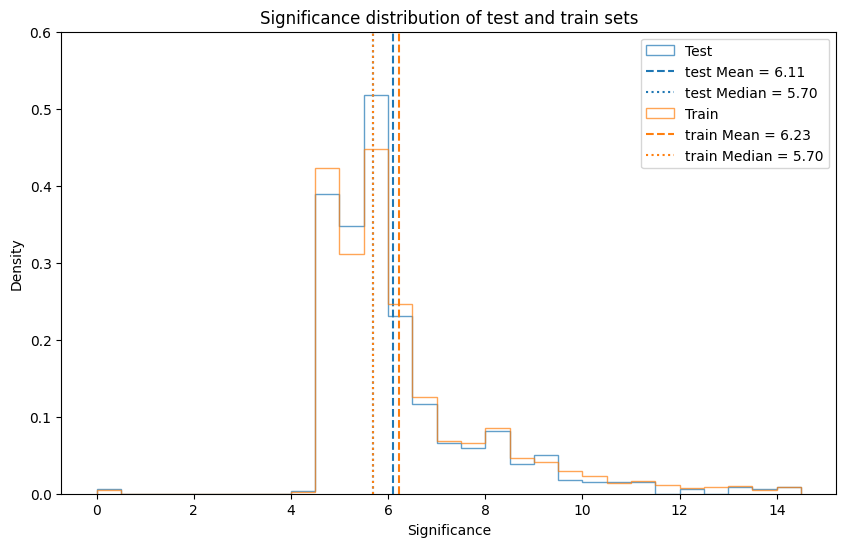

In [22]:
# training set
df_train = df[df['category'] == 'train']
train_sig = df_train['TRIG_SIG'].tolist()
print(f"Training set: {len(train_sig)}")
print(f'max: {max(train_sig)} \t min: {min(train_sig)}')
train_median = np.median(train_sig)
print(f'Median = {train_median}')

# trimming the data 5% from the top and bottom
train_sig.sort()
trimmed_train_sig = train_sig[int(len(train_sig)*0.05):int(len(train_sig)*0.95)]
print(f"Trimmed Training set: {len(trimmed_train_sig)}")
print(f'max: {max(trimmed_train_sig)} \t min: {min(trimmed_train_sig)}')

train_mean = np.mean(trimmed_train_sig)
print(f'Mean = {train_mean}')


print(' --------------------------------')

# test set
df_test = df[df['category'] == 'test']
test_sig = df_test['TRIG_SIG'].tolist()
print(f"Test set: {len(test_sig)}")
print(f'max: {max(test_sig)} \t min: {min(test_sig)}')
test_median = np.median(test_sig)
print(f'Median = {test_median}')

# trimming the data 5% from the top and bottom
test_sig.sort()
trimmed_test_sig = test_sig[int(len(test_sig)*0.05):int(len(test_sig)*0.95)]
print(f"Trimmed test set: {len(trimmed_test_sig)}")
print(f'max: {max(trimmed_test_sig)} \t min: {min(trimmed_test_sig)}')

test_mean = np.mean(trimmed_test_sig)
print(f'Mean = {test_mean}')


# plot of significance
bin_size = 0.5
bins = np.arange(0, 15, bin_size)


plt.figure(figsize=(10, 6))
plt.hist(test_sig, bins=bins, rwidth = 0.9,histtype='step', alpha=0.7 , density= True, label='Test')
plt.vlines(test_mean, 0, 1, colors=colors[0], linestyles='dashed', label=f'test Mean = {test_mean:.2f}')
plt.vlines(test_median, 0, 1, colors=colors[0], linestyles='dotted', label=f'test Median = {test_median:.2f}')

plt.hist(train_sig, bins=bins, rwidth = 0.9,histtype='step', alpha=0.7, density= True, label='Train')
plt.vlines(train_mean, 0, 1, colors=colors[1], linestyles='dashed', label=f'train Mean = {train_mean:.2f}')
plt.vlines(train_median, 0, 1, colors=colors[1], linestyles='dotted', label=f'train Median = {train_median:.2f}')

plt.xlabel('Significance')
plt.ylabel('Density')
plt.ylim(0, 0.6)
plt.legend()
plt.title('Significance distribution of test and train sets')

plt.show()

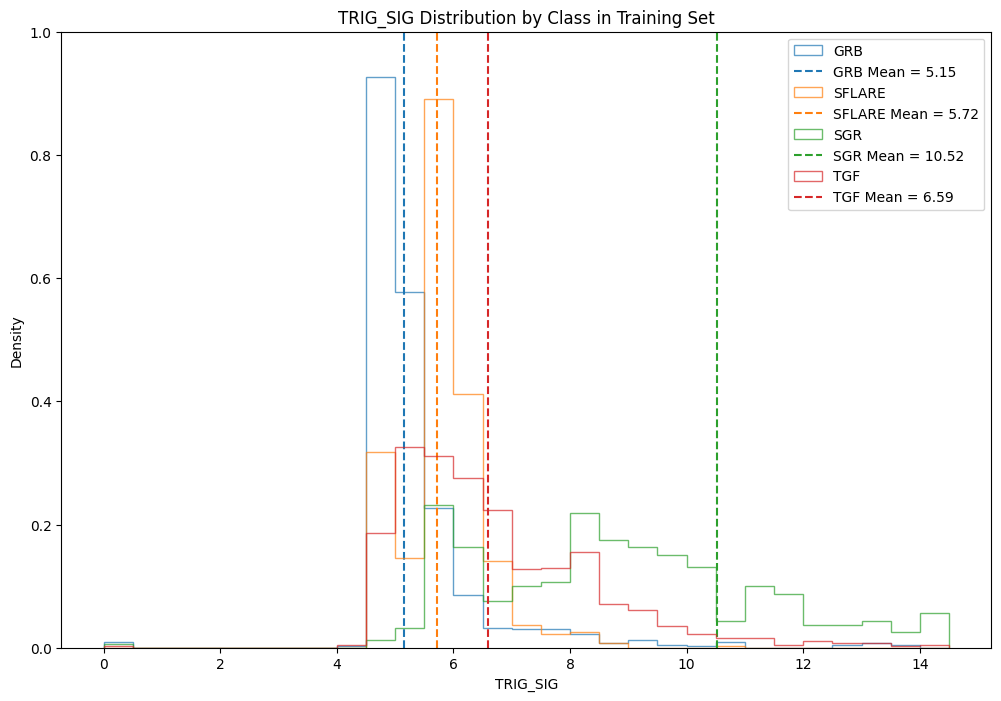

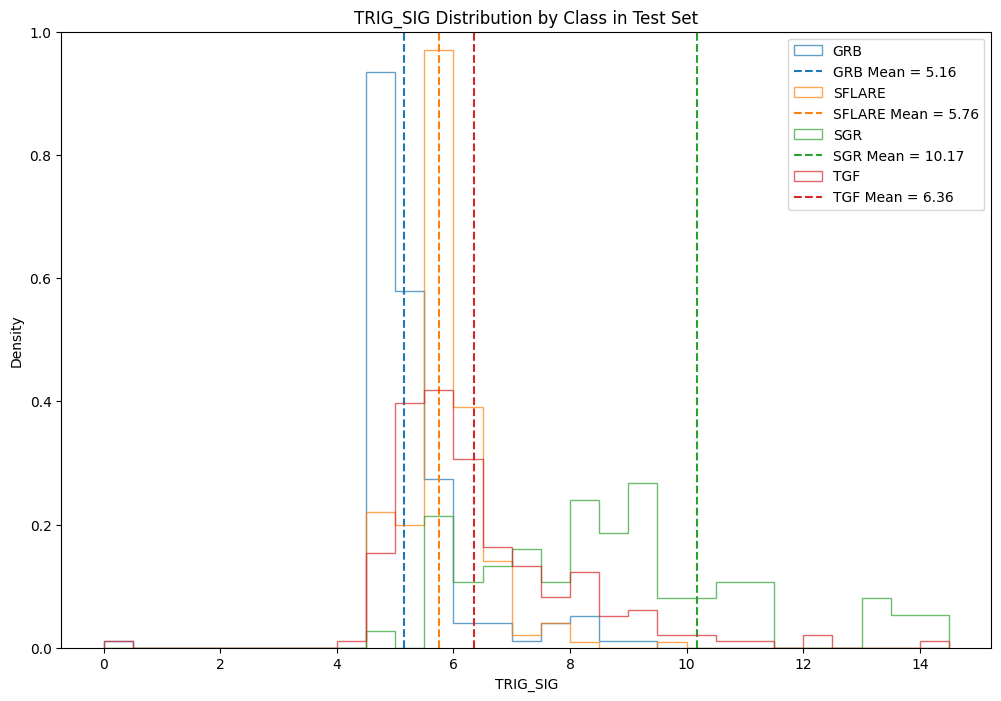

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot TRIG_SIG distribution grouped by class
def plot_trig_sig_by_class(df, bins,title):
    classes = (df['class'].unique()).tolist()  # Get unique classes
    classes.sort()
    plt.figure(figsize=(12, 8))
    
    # Plot histogram for each class
    for i,cls in enumerate(classes):
        
        class_data = (df[df['class'] == cls]['TRIG_SIG']).tolist()
        class_median = np.median(class_data)
        
        # trimming the data 5% from the top and bottom
        class_data.sort()
        trimmed_class_data = class_data[int(len(class_data)*0.05):int(len(class_data)*0.95)]
        class_mean = np.mean(trimmed_class_data)

        plt.hist(class_data, bins=np.arange(0, 15, 0.5), color=colors[i], alpha=0.7,histtype='step', density=True, label=f'{cls}')
        plt.vlines(class_mean, 0, 1,   colors=colors[i], linestyles='dashed', label=f'{cls} Mean = {class_mean:.2f}')
        # plt.vlines(class_median, 0, 1, colors=colors[i], linestyles='dotted', label=f'{cls} Median = {class_median:.2f}')
    
    plt.xlabel('TRIG_SIG')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.ylim(0, 1)
    plt.show()


# Continue with the rest of your code for significance plots
bin_size = 0.5
bins = np.arange(0, 15, bin_size)

# Plot TRIG_SIG distribution for training set grouped by class
plot_trig_sig_by_class(df_train, bins, 'TRIG_SIG Distribution by Class in Training Set')

# Plot TRIG_SIG distribution for test set grouped by class
plot_trig_sig_by_class(df_test, bins, 'TRIG_SIG Distribution by Class in Test Set')


In [23]:
from astropy.io import fits

path = r"C:\Users\arpan\current\glg_trigdat_all_bn170116238_v01.fit"
# path = error_files[0]

# Read data from FITS file
with fits.open(path, memmap=True) as hdul:
    for index, i in enumerate(hdul[0].header):
        print(i,hdul[0].header[i])
    print(index)
    

SIMPLE True
BITPIX 8
NAXIS 0
EXTEND True
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
CREATOR GBM_TRIGDAT_Reader.pl V1.27
FILETYPE TRIGDAT
FILE-VER 1.0.3
TELESCOP GLAST
INSTRUME GBM
OBSERVER Meegan
ORIGIN GIOC
DATE 2017-01-16T06:32:28
DATE-OBS 2017-01-16T05:41:08
DATE-END 2017-01-16T05:51:22
TIMESYS TT
TIMEUNIT s
MJDREFI 51910
MJDREFF 0.0007428703703703703
TSTART 506238068.160954
TSTOP 506238682.572132
DETTYPE BOTH
DATATYPE TRIGDAT
FILENAME glg_trigdat_all_bn170116238_v01.fit
TRIGTIME 506238200.259208
OBJECT GRB170116238
RADECSYS FK5
EQUINOX 2000.0
RA_OBJ 98.1333
DEC_OBJ -84.7333
ERR_RAD 14.2167
TRIGSCAL 1024
TRIG_ALG 12
CHAN_LO 3
CHAN_HI 4
ADC_LO 259
ADC_HI 1352
TRIG_SIG 4.8
GEO_LONG 142.5333
GEO_LAT 12.0333
DET_MASK 00100100000

In [24]:
for path in error_files:
    # Read data from FITS file
    with fits.open(path, memmap=True) as hdul:
        try:
            print('alg',hdul[0].header['TRIG_ALG'])
            print('scl',hdul[0].header['TRIGSCAL'])
            print('\n')
        except:
            print(f"Error in {path}")
            continue

alg 43
scl 16


alg 3
scl 32


alg 10
scl 512


alg 24
scl 32


alg 10
scl 512


alg 17
scl 4096


alg 13
scl 1024


alg 43
scl 16


